In [61]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.decomposition import PCA
from nilearn.input_data import NiftiMapsMasker

In [2]:
subject_id = '02'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)


In [3]:
def extract_prep_events_and_indices(events):
    #extracting prep events
    prep_events = events[events['trial_type'].str.contains('prep')].reset_index().drop('index', 1)

    #Renaming conditions column
    prep_events['target_location'] = '207'
    prep_events.loc[prep_events['trial_type'].str.contains('45'), 'target_location'] = '45'
    prep_events.loc[prep_events['trial_type'].str.contains('99'), 'target_location'] = '99'
    prep_events.loc[prep_events['trial_type'].str.contains('153'), 'target_location'] = '153'
    prep_events = prep_events.drop('trial_type', 1)
    prep_events = prep_events.sort_values(by='onset')
    indices = np.floor(prep_events['onset']/1.25).astype(int).values + 3

    return prep_events, indices

In [4]:
def extract_prep_images(indices, fmri_run_image):    
    #Extracting functionl images that correspond to prep times
    prep_images = image.index_img(fmri_run_image, np.ravel(np.vstack((indices, indices+1)), order = 'F'))
    return prep_images


In [49]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [50]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }


In [53]:
atlas = datasets.fetch_atlas_msdl()

/home/vm01/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [54]:
atlas.labels


['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 'Sup Front S',
 'R TPJ',
 'R Pars Op',
 'Cereb',
 'Dors PCC',
 'L Ins',
 'Cing',
 'R Ins',
 'L Ant IPS',
 'R Ant IPS']

In [112]:
masker = NiftiMapsMasker(maps_img=atlas.maps)

In [108]:
f = masker.fit_transform(fmri_image[0])

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1106: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


In [ ]:
plt.plot(f[:, np.where(np.array(atlas.labels) == 'Motor')[0][0]])


## Voxel Correlations within and across dimensions 

In [93]:
correlations = pd.DataFrame({'runs': np.repeat(np.arange(1, 11), len(masks)),
                           'block_type': np.tile(np.repeat(['Straight', 'Rotate'], len(masks)), 5),
                           'ROIs': np.tile(list(masks.keys()), 10),
                            '45_45': np.zeros(len(masks)*10),
                            '45_99': np.zeros(len(masks)*10),
                            '45_153': np.zeros(len(masks)*10),
                            '45_207': np.zeros(len(masks)*10),

                            '99_45': np.zeros(len(masks)*10),
                            '99_99': np.zeros(len(masks)*10),
                            '99_153': np.zeros(len(masks)*10),
                            '99_207': np.zeros(len(masks)*10),

                            '153_45': np.zeros(len(masks)*10),
                            '153_99': np.zeros(len(masks)*10),
                            '153_153': np.zeros(len(masks)*10),
                            '153_207': np.zeros(len(masks)*10),

                            '207_45': np.zeros(len(masks)*10),
                            '207_99': np.zeros(len(masks)*10),
                            '207_153': np.zeros(len(masks)*10),
                            '207_207': np.zeros(len(masks)*10),
                          })

In [94]:
subject_id = '02'
for run in range(1, 11):
    run_no = str(run).zfill(2)
    beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
    run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

    z_maps = {}

    for i in run_beta_maps:
        z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

    #Sorted by first number
    all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
    mean_image = image.mean_img(all_images)
    mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
    #mean_centered = all_images
    for i, key in enumerate(np.sort(list(z_maps.keys()))):
        
        z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))
        
        #For single beta map for odd vs even
        #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))

    for mask in masks.keys():
        even_dir_dict = {}
        odd_dir_dict = {}
        dir_dict = {}
        
        for direction in z_maps.keys():

            mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
            resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

            fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
            

            even = fmri_masked[0::2]
            odd = fmri_masked[1::2]
            
            #even_centered = even - np.mean(even, axis=0)
            #odd_centered = odd - np.mean(odd, axis = 0)
            
            
            even_dir_dict[direction] = np.mean(even, axis = 0)
            odd_dir_dict[direction] = np.mean(odd, axis = 0)
            dir_dict[direction] = np.mean(fmri_masked, axis = 0)
    
        for c in correlations.columns[3:]:
            even, odd = c.split('_')
            #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
            correlations.loc[((correlations['runs'] == run) & (correlations['ROIs'] == mask) ), c] = stat.pearsonr(even_dir_dict[even], odd_dir_dict[odd])[0] 
    print('Run Done: ', run)
    print(correlations)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [161]:
bw_correlations = pd.DataFrame({'run_pairs': np.tile(np.arange(1, 6), len(masks)),
                           #'block_type': np.tile(np.repeat(['Straight', 'Rotate'], 8), 5),
                                'ROIs': np.repeat(list(masks.keys()), 5),
                                '45_45': np.zeros(len(masks)*5),
                                '45_99': np.zeros(len(masks)*5),
                                '45_153': np.zeros(len(masks)*5),
                                '45_207': np.zeros(len(masks)*5),
                                                               
                                '99_45': np.zeros(len(masks)*5),
                                '99_99': np.zeros(len(masks)*5),
                                '99_153': np.zeros(len(masks)*5),
                                '99_207': np.zeros(len(masks)*5),

                                '153_45': np.zeros(len(masks)*5),
                                '153_99': np.zeros(len(masks)*5),
                                '153_153': np.zeros(len(masks)*5),
                                '153_207': np.zeros(len(masks)*5),

                                '207_45': np.zeros(len(masks)*5),
                                '207_99': np.zeros(len(masks)*5),
                                '207_153': np.zeros(len(masks)*5),
                                '207_207': np.zeros(len(masks)*5),
                               
                               })

In [162]:
subject_id = '02'
for mask in masks.keys():
    mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])

    for run in range(1, 11):
        run_no = str(run).zfill(2)
        beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
        run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')
        
        z_maps = {}
        
        for i in run_beta_maps:
            z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

        
        all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'],z_maps['99']))
        mean_image = image.mean_img(all_images)
        mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
        #print (image.index_img(mean_centered, 25))
        #mean_centered = all_images
        for i, key in enumerate(np.sort(list(z_maps.keys()))):
            z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))
            #z_maps[key] = image.index_img(mean_centered, slice(i*2,i*2+2))
            #z_maps[key] = image.index_img(mean_centered, slice(i*1,i*1+1))


        if run%2 != 0:
            dir_dict_straight = {}
            for direction in z_maps.keys():

                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_straight[direction] = np.mean(fmri_masked, axis = 0)
                
        else:
            
            dir_dict_rotate = {}
            for direction in z_maps.keys():
                resampled_mask = image.resample_to_img(mask_image, z_maps[direction], interpolation='nearest')
                #nifti_masker = NiftiMasker(mask_img=resampled_mask, standardize=True)

                fmri_masked = masking.apply_mask(z_maps[direction], mask_img=resampled_mask)
                dir_dict_rotate[direction] = np.mean(fmri_masked, axis = 0)
                
            for c in bw_correlations.columns[2:]:
                straight, rotate = c.split('_')
                #print(stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0])
                bw_correlations.loc[((bw_correlations['run_pairs'] == int(run/2)) & (bw_correlations['ROIs'] == mask) ), c] = stat.pearsonr(dir_dict_straight[straight], dir_dict_rotate[rotate])[0]

        

    print('Run Done: ', run)
    print(bw_correlations)

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.077016 -0.044433  0.155129 -0.027107   
1           2       premotor  0.169148 -0.044240 -0.050181 -0.115497   
2           3       premotor  0.165194 -0.152282  0.029376 -0.060902   
3           4       premotor -0.124359 -0.188288  0.226136  0.123986   
4           5       premotor  0.207252 -0.074794 -0.091030 -0.080817   
5           1          motor  0.000000  0.000000  0.000000  0.000000   
6           2          motor  0.000000  0.000000  0.000000  0.000000   
7           3          motor  0.000000  0.000000  0.000000  0.000000   
8           4          motor  0.000000  0.000000  0.000000  0.000000   
9           5          motor  0.000000  0.000000  0.000000  0.000000   
10          1             v1  0.000000  0.000000  0.000000  0.000000   
11          2             v1  0.000000  0.000000  0.000000  0.000000   
12          3             v1  0.000000  0.000000  

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.077016 -0.044433  0.155129 -0.027107   
1           2       premotor  0.169148 -0.044240 -0.050181 -0.115497   
2           3       premotor  0.165194 -0.152282  0.029376 -0.060902   
3           4       premotor -0.124359 -0.188288  0.226136  0.123986   
4           5       premotor  0.207252 -0.074794 -0.091030 -0.080817   
5           1          motor -0.045145  0.023557  0.055055 -0.018007   
6           2          motor  0.154254 -0.136367  0.035326 -0.089867   
7           3          motor  0.171790 -0.214165  0.081434 -0.051814   
8           4          motor -0.117727 -0.215798  0.223344  0.153088   
9           5          motor  0.142516 -0.149638  0.037275 -0.024242   
10          1             v1  0.051185  0.052127 -0.065698 -0.047082   
11          2             v1  0.179358 -0.000753 -0.015247 -0.203367   
12          3             v1  0.244316 -0.047149 -

Run Done:  10
    run_pairs           ROIs     45_45     45_99    45_153    45_207  \
0           1       premotor -0.077016 -0.044433  0.155129 -0.027107   
1           2       premotor  0.169148 -0.044240 -0.050181 -0.115497   
2           3       premotor  0.165194 -0.152282  0.029376 -0.060902   
3           4       premotor -0.124359 -0.188288  0.226136  0.123986   
4           5       premotor  0.207252 -0.074794 -0.091030 -0.080817   
5           1          motor -0.045145  0.023557  0.055055 -0.018007   
6           2          motor  0.154254 -0.136367  0.035326 -0.089867   
7           3          motor  0.171790 -0.214165  0.081434 -0.051814   
8           4          motor -0.117727 -0.215798  0.223344  0.153088   
9           5          motor  0.142516 -0.149638  0.037275 -0.024242   
10          1             v1  0.051185  0.052127 -0.065698 -0.047082   
11          2             v1  0.179358 -0.000753 -0.015247 -0.203367   
12          3             v1  0.244316 -0.047149 -

In [179]:
correlations_melt = correlations.melt(id_vars=['runs', 'block_type', 'ROIs'], var_name = 'correlations', value_name='corr')

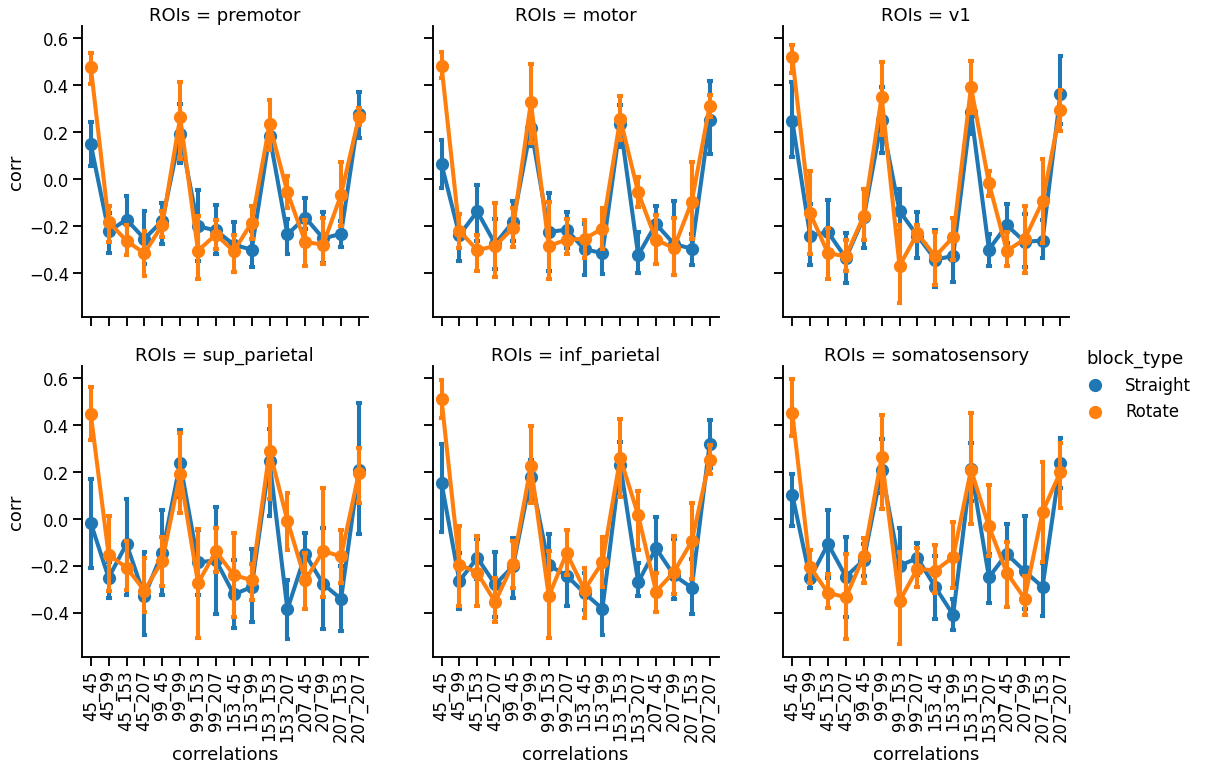

In [180]:
sns.set_context('talk')
g = sns.catplot(x = 'correlations', y = 'corr', hue = 'block_type', col = 'ROIs', col_wrap = 3,
                kind = 'point', data = correlations_melt.loc[correlations_melt['runs'] < 11], capsize = 0.1)

g.set_axis_labels().set_xticklabels(rotation = 90)
plt.savefig('plots_for_bb/')

In [170]:
bw_correlations_melt = bw_correlations.melt(id_vars=['run_pairs', 'ROIs'], var_name = 'correlations', value_name='corr')

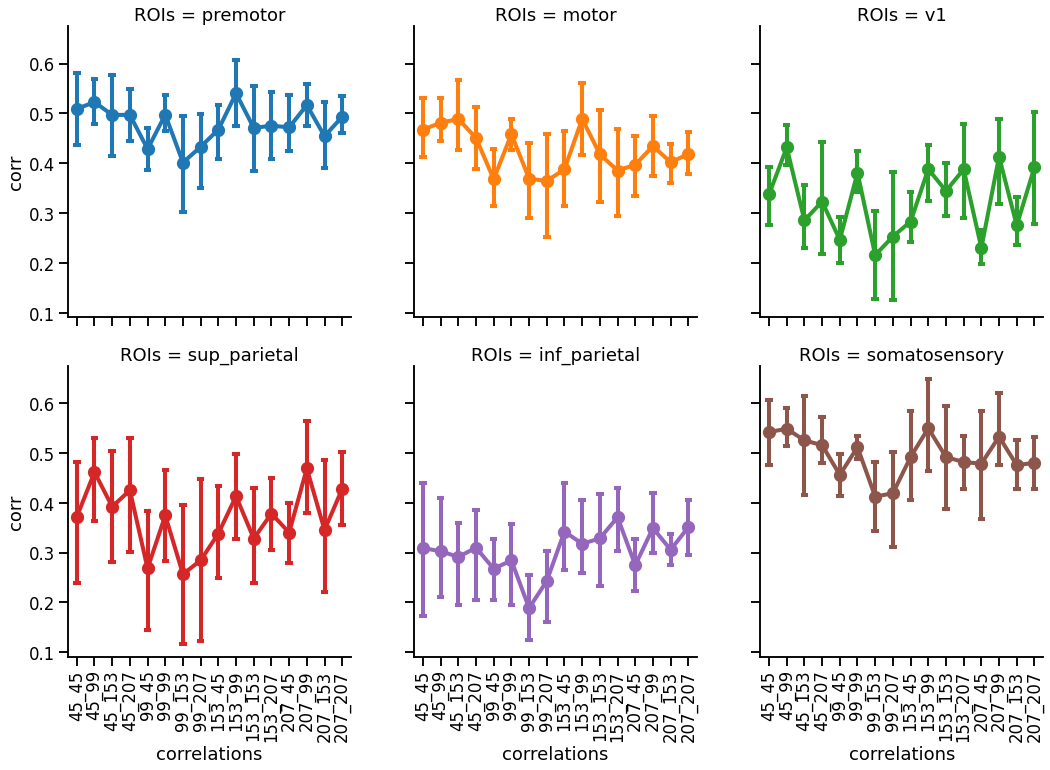

In [127]:
sns.set_context('talk')

ax = sns.catplot(x = 'correlations', y = 'corr', hue = 'ROIs', col = 'ROIs', col_wrap=3,
                 kind = 'point', capsize = 0.2,
                 data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] <= 5) )])

ax.set_axis_labels().set_xticklabels(rotation = 90)
plt.savefig('plots_for_bb/bw_corr_all_pairs_non_mc.png', dpi = 600)

In [165]:
aim = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    aim.append((int(i[0]) - (int(i[1]) - 90)))

In [166]:
bw_correlations_melt['aim_diff'] = aim

In [167]:
bw_correlations_melt = bw_correlations_melt[~( (bw_correlations_melt['aim_diff'] == -72 ) | (bw_correlations_melt['aim_diff'] == 252 ))]

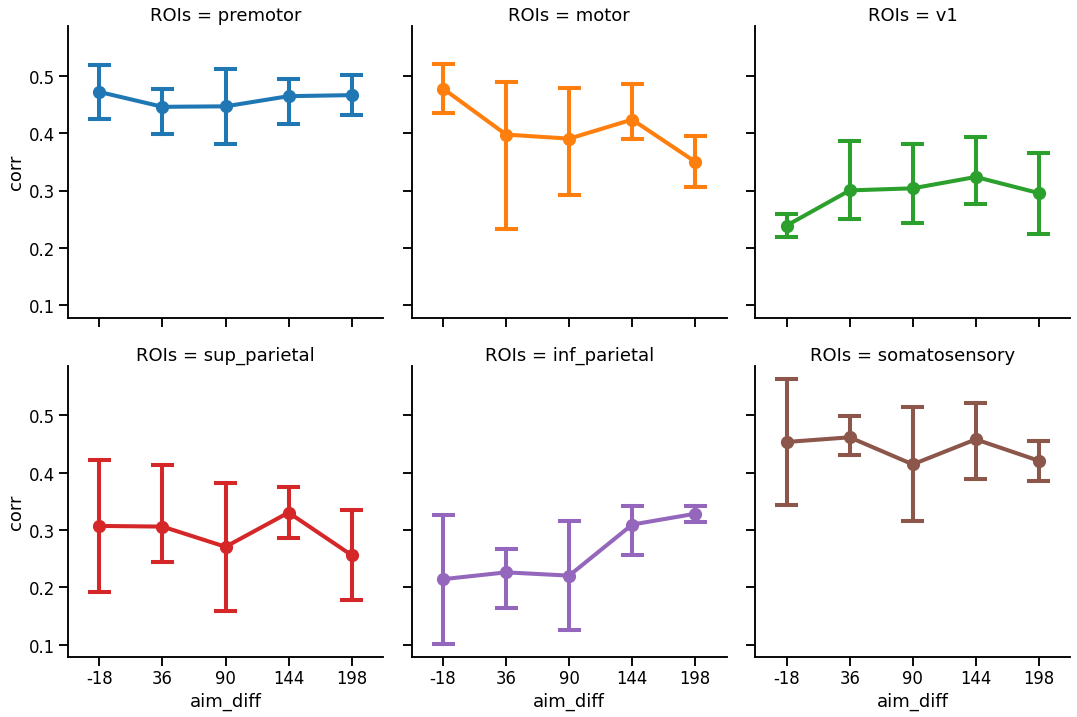

In [169]:
sns.catplot(x = "aim_diff", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['aim_diff'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 1))], 
            kind = 'point', capsize = 0.3)
#plt.savefig('plots_for_bb/bw_corr_aim_diff_last_pair_non_mc.png', dpi = 600)

In [171]:
away = []
for i in bw_correlations_melt.correlations.str.split('_').values:
    away.append(np.abs((int(i[0]) - int(i[1]))/54))
    
bw_correlations_melt['targets_away'] = away

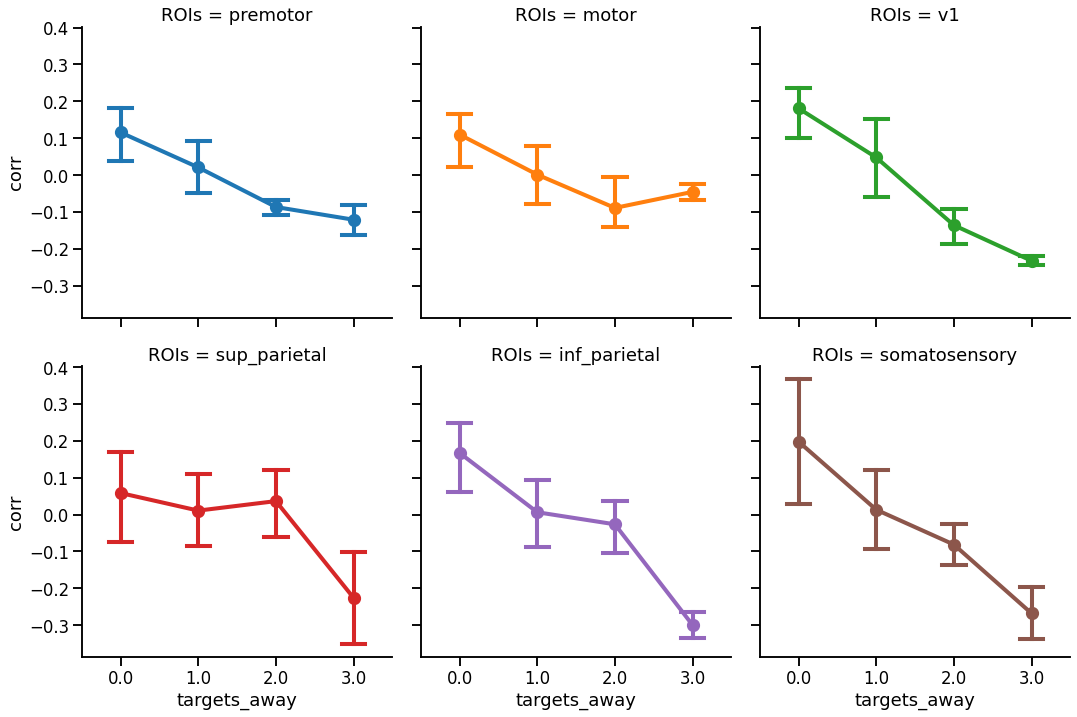

In [176]:
sns.catplot(x = "targets_away", y = "corr", hue = 'ROIs', col = 'ROIs', col_wrap = 3,
            order = np.sort(np.unique(bw_correlations_melt['targets_away'])),
            data = bw_correlations_melt.loc[((bw_correlations_melt['run_pairs'] == 5))], 
            kind = 'point', capsize = 0.3)
plt.savefig('plots_for_bb/bw_corr_targ_away_last_pair.png', dpi = 600)

In [195]:

from IPython.display import Image
Image(filename='plots_for_bb/bw_corr_targ_away_last_pair.png')


In [110]:
a.mro()

NameError: name 'a' is not defined